In [1]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
df = pd.read_csv('train_fs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242562 entries, 0 to 242561
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   NAME_INCOME_TYPE             242562 non-null  int64
 1   NAME_HOUSING_TYPE            242562 non-null  int64
 2   DAYS_BIRTH                   242562 non-null  int64
 3   DAYS_EMPLOYED                242562 non-null  int64
 4   DAYS_REGISTRATION            242562 non-null  int64
 5   DAYS_ID_PUBLISH              242562 non-null  int64
 6   REGION_RATING_CLIENT_W_CITY  242562 non-null  int64
 7   EXT_SOURCE_2                 242562 non-null  int64
 8   EXT_SOURCE_3                 242562 non-null  int64
 9   DAYS_LAST_PHONE_CHANGE       242562 non-null  int64
 10  Gender_Map                   242562 non-null  int64
 11  TARGET                       242562 non-null  int64
dtypes: int64(12)
memory usage: 22.2 MB


In [3]:
df.TARGET.value_counts()

TARGET
0    121281
1    121281
Name: count, dtype: int64

In [4]:
X = df.drop(columns=['TARGET'])
y = df[['TARGET']]

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Evaluation Method

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate, StratifiedKFold


def eval_classification(model, X_train, X_test, y_train, y_test, n_splits=5):
    # Evaluate on the test set
    y_pred_test = model.predict(X_test)

    # StratifiedKFold for cross-validation with stratified sampling
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_test_results = cross_validate(model, X_test, y_test, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)
    cv_train_results = cross_validate(model, X_train, y_train, scoring=['roc_auc'],
                                cv=cv, return_train_score=False)


    # Display metrics for the training set
    print("Metrics for the Test Set:")
    print("Accuracy: %.2f" % accuracy_score(y_test, y_pred_test))
    print("Precision: %.2f" % precision_score(y_test, y_pred_test))
    print("Recall: %.2f" % recall_score(y_test, y_pred_test))
    print("F1-Score: %.2f" % f1_score(y_test, y_pred_test))
    print()

    # Display cross-validation results
    print("Metrics Using Cross Validation:")
    print(f"Mean ROC-AUC (Test): {cv_test_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Test): {cv_test_results['test_roc_auc'].std():.2f}")
    print()
    print(f"Mean ROC-AUC (Train): {cv_train_results['test_roc_auc'].mean():.2f}")
    print(f"Std ROC-AUC (Train): {cv_train_results['test_roc_auc'].std():.2f}")

## XGBoost Modeling

In [7]:
base_model = XGBClassifier()
base_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [8]:
eval_classification(base_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.77
Precision: 0.76
Recall: 0.80
F1-Score: 0.78

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.82
Std ROC-AUC (Test): 0.00

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


## Hyperparameter Tunning

In [9]:
xgb_model = XGBClassifier()

In [10]:
# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}


In [12]:
best_xgb_model = grid_search.best_estimator_

In [13]:
eval_classification(best_xgb_model, X_train, X_test, y_train, y_test)

Metrics for the Test Set:
Accuracy: 0.78
Precision: 0.77
Recall: 0.80
F1-Score: 0.78

Metrics Using Cross Validation:
Mean ROC-AUC (Test): 0.82
Std ROC-AUC (Test): 0.00

Mean ROC-AUC (Train): 0.85
Std ROC-AUC (Train): 0.00


## Feature Importance

                        Feature  Importance
4             DAYS_REGISTRATION    0.053211
1             NAME_HOUSING_TYPE    0.057465
9        DAYS_LAST_PHONE_CHANGE    0.059061
5               DAYS_ID_PUBLISH    0.059401
3                 DAYS_EMPLOYED    0.067922
6   REGION_RATING_CLIENT_W_CITY    0.069997
2                    DAYS_BIRTH    0.075978
0              NAME_INCOME_TYPE    0.081827
8                  EXT_SOURCE_3    0.150123
7                  EXT_SOURCE_2    0.151652
10                   Gender_Map    0.173363


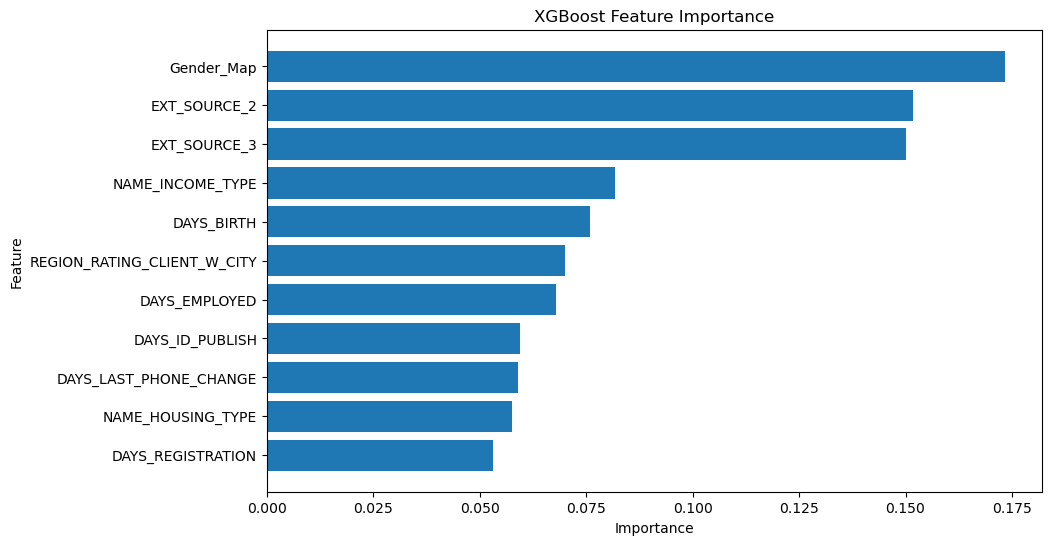

In [14]:
# Get feature importances
feature_importances = best_xgb_model.feature_importances_

# Get feature names (optional)
feature_names = [f'Feature {i}' for i in range(X.shape[1])]

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# Print or plot the feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()